In [1]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install -U gensim
stopwords = stopwords.words('english')

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Loading the datasets

guard_df = pd.read_csv('/Users/sketcha/lda/guardian.csv', sep=',')
print('For Guardian original Number of Columns: {}, rows: {}'.format(guard_df.shape[1], guard_df.shape[0]) )

columns = ['firstPublicationDate', 'webUrl', 'bodyText']
guard_df = guard_df[columns]
guard_df.drop_duplicates(subset ="bodyText", inplace = True)

print(guard_df.shape)
guard_df.dropna(inplace=True)

guard_df.head()

For Guardian original Number of Columns: 46, rows: 30599
(30572, 3)
After droping duplicate rows and unneccesary columns
 Number of Columns: 3        , rows: 30570


,firstPublicationDate,webUrl,bodyText
0,2020-03-01T01:10:20Z,https://www.theguardian.com/world/live/2020/ma...,We are about to close this live blog on the co...
1,2020-03-01T22:19:16Z,https://www.theguardian.com/world/2020/mar/02/...,With novel coronavirus (Covid-19) spreading wi...
2,2020-03-01T19:55:28Z,https://www.theguardian.com/australia-news/202...,"Good morning, this is Richard Parkin bringing ..."
3,2020-03-01T14:36:28Z,https://www.theguardian.com/world/2020/mar/01/...,New coronavirus infections spiked dramatically...
4,2020-03-01T13:47:36Z,https://www.theguardian.com/world/2020/mar/01/...,Government lawyers are assessing the possibili...


**Pre-processing**

In [3]:
# Pre-processing steps

%timeit
# initalizing the werdnet lemmatizer
lm = WordNetLemmatizer()
# creating a new column to store rows after processing
guard_df['post_processed'] = np.nan

stopwords.extend(['advertisement', 'supported'])
def processing(content):

    content = content.split(' ')
#   removing stopwords
    content = [word.strip().lower() for word in content if word.lower() not in stopwords]
#   removing punctuations
    rx = re.compile('([&#.:?!-()])*')
    content = [rx.sub('', word) for word in content]
    
    content = [word for word in content if len(word)>1 and word.isalpha()]
#   lemmatizing    
    content = [lm.lemmatize(word) for word in content]

    return ' '.join(content)

# removing opinion articles
for i in range(len(guard_df)):
    if 'opinion' not in guard_df.iloc[i,1]:
        guard_df.iloc[i,-1] = processing(guard_df.iloc[i,2]) 


guard_df.dropna(inplace=True)
guard_df.head()

,firstPublicationDate,webUrl,bodyText,post_processed
0,2020-03-01T01:10:20Z,https://www.theguardian.com/world/live/2020/ma...,We are about to close this live blog on the co...,close live blog coronavirus latest summary key...
1,2020-03-01T22:19:16Z,https://www.theguardian.com/world/2020/mar/02/...,With novel coronavirus (Covid-19) spreading wi...,novel coronavirus spreading astonishing world ...
2,2020-03-01T19:55:28Z,https://www.theguardian.com/australia-news/202...,"Good morning, this is Richard Parkin bringing ...",good richard parkin bringing main story monday...
3,2020-03-01T14:36:28Z,https://www.theguardian.com/world/2020/mar/01/...,New coronavirus infections spiked dramatically...,new coronavirus infection spiked dramatically ...
4,2020-03-01T13:47:36Z,https://www.theguardian.com/world/2020/mar/01/...,Government lawyers are assessing the possibili...,government lawyer assessing possibility delayi...


In [4]:
# Frequency filtering

import gensim.corpora as corpora
#decomposing sentences into tokens 
tokens = [sentence.split(' ') for sentence in guard_df['post_processed'] ]

# Create Dictionary
dct = corpora.Dictionary(tokens)
print('Unique words before filtering', len(dct))
# no_below= 30
dct.filter_extremes(no_below= 20, no_above=0.25 )
print('Unique words after filtering', len(dct))
# Create Corpus
corpus = [dct.doc2bow(token) for token in tokens]

Unique words before filtering 127404
Unique words after filtering 24066


**Coherence**

In [108]:
# Obtaining coherence results

%%time
from gensim.models import CoherenceModel
import time

scores = []
for k in range(1,26):
  lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dct, num_topics=k, 
                                       random_state=100, chunksize=128, passes=10,
                                       per_word_topics=True)

  coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dct, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print( 'coherence_lda', coherence_lda)
  # time.sleep(20)

  scores.append(coherence_lda)

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


coherence_lda 0.3082560250556693
coherence_lda 0.4429429001018651
coherence_lda 0.5666139430418554
coherence_lda 0.5733201222657944
coherence_lda 0.5923156788161696
coherence_lda 0.5900387786201459
coherence_lda 0.6101640496392441
coherence_lda 0.5747565427955793
coherence_lda 0.5952643523070082
coherence_lda 0.5803172213503078
coherence_lda 0.5949107656724091
coherence_lda 0.585653724221128
coherence_lda 0.5920435174008246
coherence_lda 0.6072093885525204
coherence_lda 0.5824320552244878
coherence_lda 0.5857364295819247
coherence_lda 0.6159586553160659
coherence_lda 0.599246625664574
coherence_lda 0.5951990139135923
coherence_lda 0.6046625580558734
coherence_lda 0.6073039553709348
coherence_lda 0.6074665253516728
coherence_lda 0.6112462462591264
coherence_lda 0.603199821038031
coherence_lda 0.6178660782833407
CPU times: user 5h 11min 22s, sys: 25min 8s, total: 5h 36min 31s
Wall time: 5h 1min 36s


/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


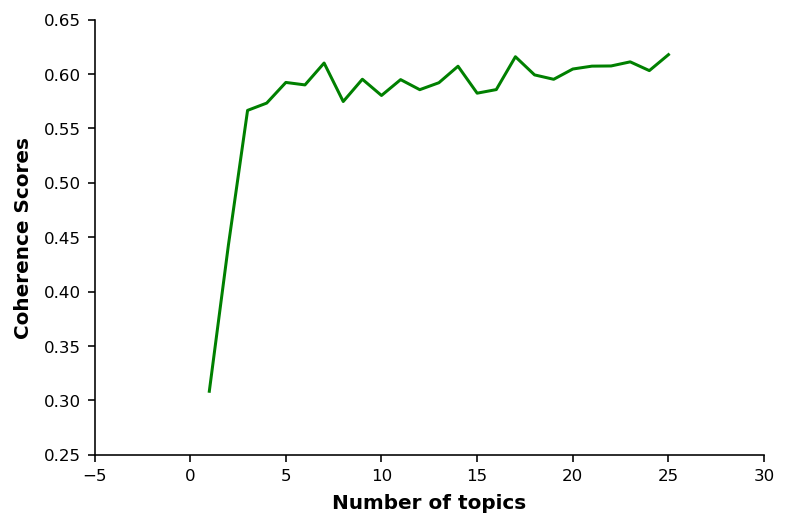

In [113]:
# Plotting coherence results

selected_topics = np.argmax(scores)+3
plt.plot(list(range(1,26)), scores, color= "green")
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('guardian_coherence')

<b> Final Model </b>

In [5]:
# constructing the lda model

selected_topics = 7

lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dct, num_topics=selected_topics, 
                                           random_state=100, chunksize=128, passes=10 )

In [106]:
#save lda model 
lda_model.save("guardian.model")

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Visualization tool**

In [6]:
# !pip install pyLDAvis
import pyLDAvis.gensim_models
# import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dct)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.221482  0.131170       1        1  19.079137
0     -0.056481  0.020892       2        1  16.604950
5      0.159585  0.004283       3        1  15.056781
3     -0.187303 -0.073936       4        1  11.667336
4     -0.066900  0.177259       5        1  10.884871
7      0.112744 -0.235950       6        1  10.449868
1     -0.123172  0.084871       7        1   8.552748
2     -0.059956 -0.108589       8        1   7.704309, topic_info=            Term           Freq          Total Category  logprob  loglift
1452     vaccine  104944.000000  104944.000000  Default  30.0000  30.0000
101   australian   27650.000000   27650.000000  Default  29.0000  29.0000
100    australia   26729.000000   26729.000000  Default  28.0000  28.0000
1419       trump   27191.000000   27191.000000  Default  27.0000  27.0000
4769       biden   24843.000000   24843.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
1370        test    4961.588470   22737.319556   Topic8  -5.4278   1.0411
1067    question    4071.748975   16089.666365   Topic8  -5.6255   1.1893
1010    positive    3888.724634   16565.434655   Topic8  -5.6715   1.1142
340     decision    3821.005000   16759.571382   Topic8  -5.6890   1.0849
872      morning    3661.300482   12139.331988   Topic8  -5.7317   1.3648

[597 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6433       8  0.999638         aap
1526       6  0.110563         abc
1526       8  0.889481         abc
4891       8  0.998792  aboriginal
4892       3  0.999583       abuse
...      ...       ...         ...
1524       2  0.236258       young
1524       3  0.438437       young
1524       4  0.002998       young
1524       8  0.029782       young
23900      7  0.999005      zahawi

[1480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 6, 4, 5, 8, 2, 3])

**Plotting**

In [ ]:
# in order to use the style, you must put the 'apa.mplstyle' file inside of 'stylelib' folder. please see: https://github.com/sollan/apa.mplstyle

import matplotlib
matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle') # selecting the style sheet

In [ ]:
# labelling the topics 

topic_names = ['Sports', 'Vaccination',  'Policy', 'Economy', 'U.S Politics', 'Travel Restrictions',
               'Australian News']
predicted_topics = lda_model[corpus]

probs, topics = [], []
for k in predicted_topics:
  # print(k)
  k.sort(key=lambda x:x[1])
  topics.append(topic_names[ k[0][0] ] ), probs.append(k[0][1])

guard_df['Predicted Topic'] = topics
guard_df['Probability'] = probs

dates = [row.split('T')[0] for row in guard_df['firstPublicationDate'] ]
guard_df['firstPublicationDate'] = dates


/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


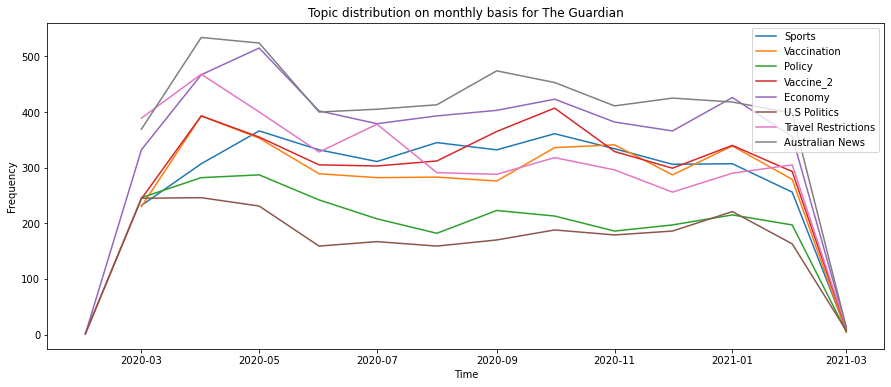

In [11]:
# Plotting for the topics discussed in the results section only

topic_name = ['Economy', 'Travel Restrictions', 'U.S Politics', 'Vaccination' ]

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)

plt.figure()
for i in range(len(topics_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_names[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    
    plt.plot(curr.x_axis, curr['Predicted Topic'], label=topics_name[i] )
    
plt.legend(loc=0)
plt.title('Topic distribution on a monthly basis for The Guardian')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plotting for the topics "Vaccination" and "Travel Restrictions"

topic_name = ['Vaccination', 'Travel Restrictions' ]

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)

plt.figure()
for i in range(len(topics_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_names[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    
    plt.plot(curr.x_axis, curr['Predicted Topic'], label=topics_name[i] )
    
plt.legend(loc=0)
plt.title('Topic distribution on a monthly basis for The Guardian')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


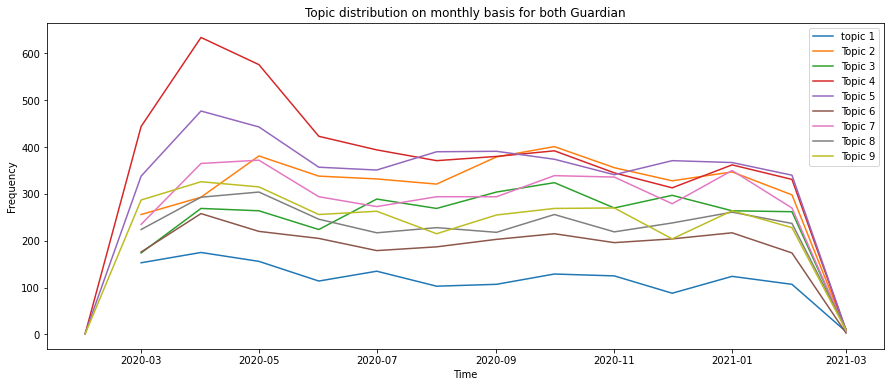

In [13]:
# Plotting for the topic "Economy"

topic_name = ['Economy']

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)

plt.figure()
for i in range(len(topics_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_names[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    
    plt.plot(curr.x_axis, curr['Predicted Topic'], label=topics_name[i] )
    
plt.legend(loc=0)
plt.title('Topic distribution on a monthly basis for The Guardian')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


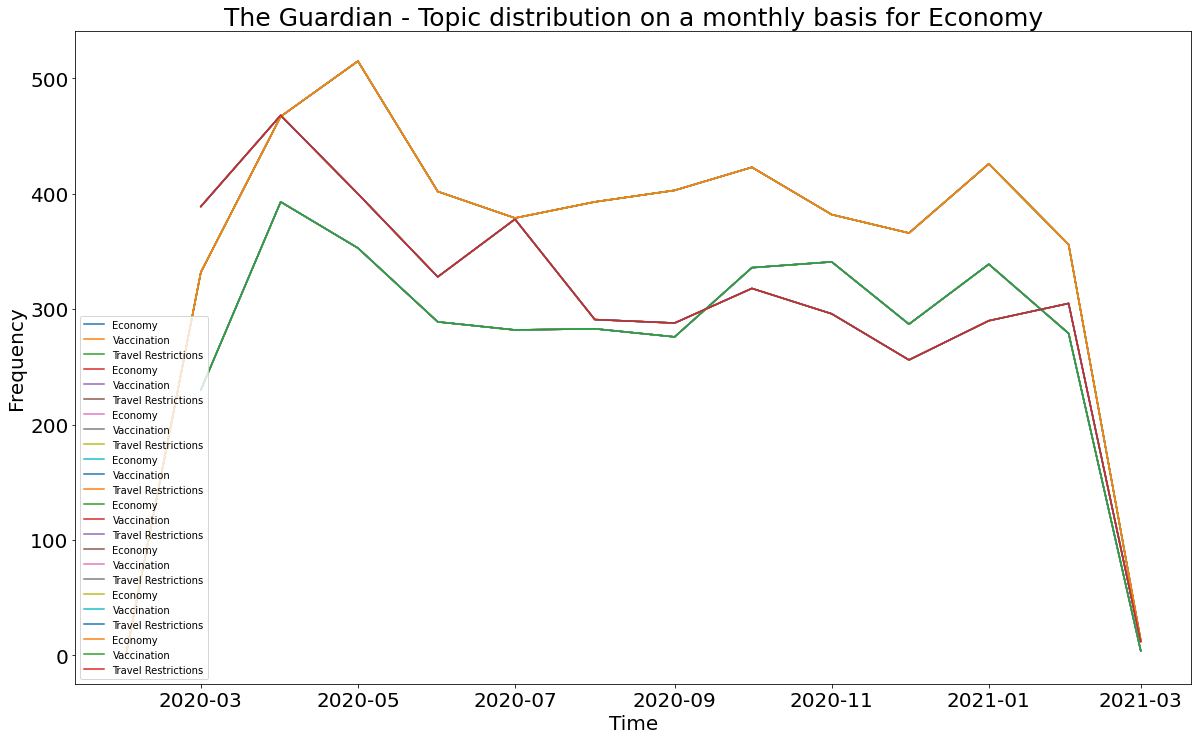

In [23]:
#Plotting for the topic "U.S Politics"

topic_name = ['U.S Politics']

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)

plt.figure(figsize=(15,6))
for i in range(len(topics_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_names[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    
    plt.plot(curr.x_axis, curr['Predicted Topic'], label=topics_name[i] )
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [78]:
import matplotlib

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle') # selecting the style sheet

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


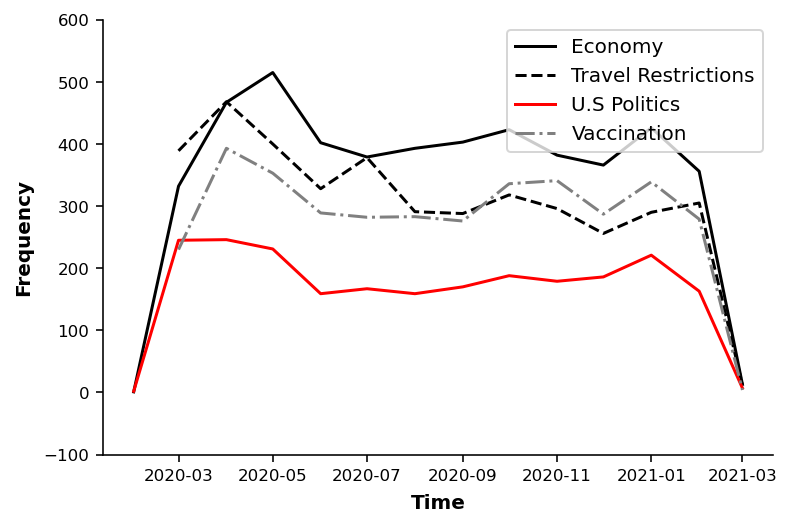

In [105]:
topic_name= ['Economy', 'Travel Restrictions', 'U.S Politics', 'Vaccination']

dates = [row.split('T')[0] for row in guard_df['firstPublicationDate'] ]
guard_df['firstPublicationDate'] = dates

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i])
    
    
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('guardian_alltopics_plot')
plt.show()

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


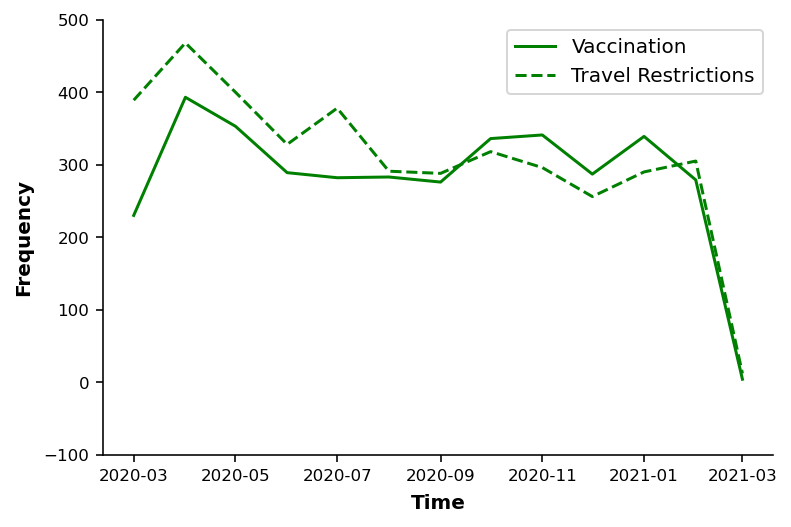

In [98]:
topic_name= ['Vaccination', 'Travel Restrictions']

dates = [row.split('T')[0] for row in guard_df['firstPublicationDate'] ]
guard_df['firstPublicationDate'] = dates

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i], color= 'green')
    
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('vaccination_travel_example')
plt.show()

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


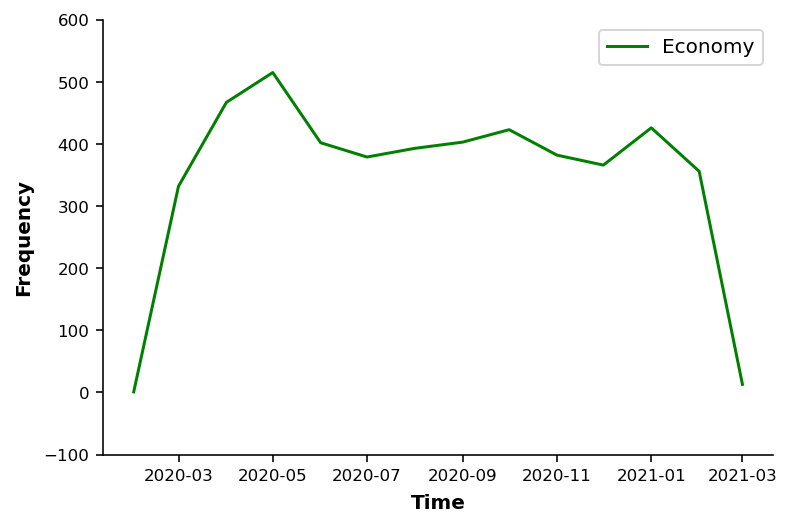

In [100]:
topic_name= ['Economy']

dates = [row.split('T')[0] for row in guard_df['firstPublicationDate'] ]
guard_df['firstPublicationDate'] = dates

guard_df['new_date'] =  pd.to_datetime(guard_df['firstPublicationDate'], format='%Y-%m-%d')
guard_df = guard_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = guard_df[guard_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')
    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i], color= 'green')
    
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('guardian_economy_plot')
plt.show()

In [97]:
df.reset_index(drop=True, inplace=True)
df.to_csv('topics.csv', index=True, columns=['firstPublicationDate', 'content', 'Predicted Topic'], sep=',')

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "None of [Index(['pub_date', 'content', 'Predicted Topic'], dtype='object')] are in the [columns]"

In [ ]:
# viewig top documents for a given topic

#topic_name = ['']

x = guard_df[ guard_df['Predicted Topic'] == topics_name[0] ]
x = x.sort_values('Probability', ascending=False)

x = x[['content', 'keywords']]
x.head(7)